<a href="https://colab.research.google.com/github/umbertogagl97/LivDet_art/blob/main/examples/Attacco_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 65.2 MB/s 
     |████████████████████████████████| 26.3 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


##Import librerie

In [2]:
import torch
import numpy as np
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

##Import LDART

In [3]:
!pip install git+https://github.com/umbertogagl97/LivDet_art.git

  Cloning https://github.com/umbertogagl97/LivDet_art.git to /tmp/pip-req-build-l4qhoe7t
  Running command git clone -q https://github.com/umbertogagl97/LivDet_art.git /tmp/pip-req-build-l4qhoe7t
  Created wheel for LivDet-ART: filename=LivDet_ART-0.0.1-py3-none-any.whl size=19330 sha256=78d5e4e7e7519e030b252718623967e93c74252e809a2b8e7ba05a839fe49b69
  Stored in directory: /tmp/pip-ephem-wheel-cache-milt70xz/wheels/00/53/f6/1a9221b6c8999525e0a7ad4416ed7ce2ed105427f3bfb7b2d4
Successfully built LivDet-ART


In [4]:
from ldart.utils import *

##Check device


In [5]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.10.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Def path

In [6]:
#scanner
scanner_name = 'GreenBit'

#load modello
path_model = F"/content/gdrive/My Drive/Scanner/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

#predizioni testset originale
pd_preds=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}_con_normalize.xlsx'

##Collegamento google drive

In [7]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset

In [8]:
test_dataset = datasets.ImageFolder(pathTestset,transform=transf_load)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [9]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)

##Nomi classi

In [10]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


##Min Max dataset

In [11]:
a,_=next(iter(testgen))
_min,_max=torch.min(a),torch.max(a)
print(_min,_max)

tensor(0.0706) tensor(1.)


##Transf_init

In [12]:
size_init=np.array(a.shape[2:4])
transf_init=transforms.Resize(size=(size_init[0],size_init[1]),interpolation=InterpolationMode.NEAREST)

#**Riduzione dataset**

In [13]:
test_dataset.samples=test_dataset.samples[1004:1005]

dim_set=len(test_dataset)
print(dim_set)

1


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [14]:
if scanner_name=='DigitalPersona':
  model = models.densenet201(pretrained=True,progress=True)
else: model = models.vgg19(pretrained=True,progress=True)

#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [15]:
if scanner_name=='DigitalPersona':
  model.classifier=nn.Linear(1920,2) #per densenet201
else: model.classifier[6]=nn.Linear(4096,2) #per vgg19


#print(model) 

##Load pesi

In [16]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [17]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(_min,_max),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(224, 224, 3),
    nb_classes=class_number
)

##Attacco

In [19]:
from ldart.attacks.IFGM import IterativeFastGradientMethod
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import time

# FGM
attack = IterativeFastGradientMethod(estimator=classifier, eps=1000,eps_step=0.001,class_target=classes_name.index('Live'),max_iter=100,confidence=0.7)

list_print=sorted(random.sample(range(dim_set),1))

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
perturb_print=[]
Test_p = pd.DataFrame()
model.eval()
model.cuda()
# starting time
start = time.time()
i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  #cv2.imwrite("img_orig.png",x_test[0].transpose(1,2,0)*255)

  x_test_adv=attack.generate(x=x_test,y=y_test)
  perturb=compute_perturb(x_test[0],x_test_adv[0],transf_init)

  #x_test_adv=x_test_adv[0,:,:,:]
  #x_test_adv=(x_test_adv-np.min(x_test_adv))/(np.max(x_test_adv)-np.min(x_test_adv))
  
  x_test_adv=torch.Tensor(x_test_adv)
  #x_test_adv=x_test_adv.unsqueeze_(0)
  
  if x_test_adv.shape[2]==224:
    x_test_adv=transf_init(x_test_adv)

  pred,probabilities,_=test_average(classifier,x_test_adv,transf_init)
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[pred], #qui metti pred
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)

  #print
  if i-1 in list_print:
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)
    perturb_print.append(perturb)

# end time
end = time.time()

x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)
perturb_print=np.array(perturb_print)

# total time taken
import datetime
time_exe=int(end - start)
time_exe=datetime.timedelta(seconds=time_exe)

print(f"\nRuntime of the program is {time_exe}")

Elem: 1/1
Runtime of the program is 0:00:01


##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [23]:
Test_orig=pd.read_excel(pd_preds)
print_acc(Test_orig) 


Accuracy: 95.56
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [24]:
print_acc(Test_p)


Accuracy: 0.0
Shape dataframe: (1, 4)


####Spoof

prima

In [25]:
accuracy_class('Spoof',Test_orig)

# imgSpoof: 1500
Numero di predizioni Spoof giuste: 1470
Accuracy : 98.0


dopo

In [26]:
accuracy_class('Spoof',Test_p)

# imgSpoof: 1
Numero di predizioni Spoof giuste: 0
Accuracy : 0.0


####Live

prima

In [27]:
accuracy_class('Live',Test_orig)

# imgLive: 1000
Numero di predizioni Live giuste: 919
Accuracy : 91.9


dopo

In [28]:
accuracy_class('Live',Test_p)

# imgLive: 0
Numero di predizioni Live giuste: 0
Accuracy : nan


/usr/local/lib/python3.7/dist-packages/ldart/utils.py:244: RuntimeWarning: invalid value encountered in long_scalars
  print("Accuracy : "+str(round(n_class/n*100,2)))


####numero img spoof predette live con prob >70%

In [29]:
p=Test_p.loc[Test_p['real']=='Spoof']
p=p.loc[p['predicted']=='Live']
print("img spoof-live: "+str(p.count(0)[0]))
p=p.loc[p['prob_live']>=0.7]
print("img con prob_live>70%: "+str(p.count(0)[0]))

img spoof-live: 1
img con prob_live>70%: 1


##subplot

###test finale

['Spoof']
IMMAGINE  0


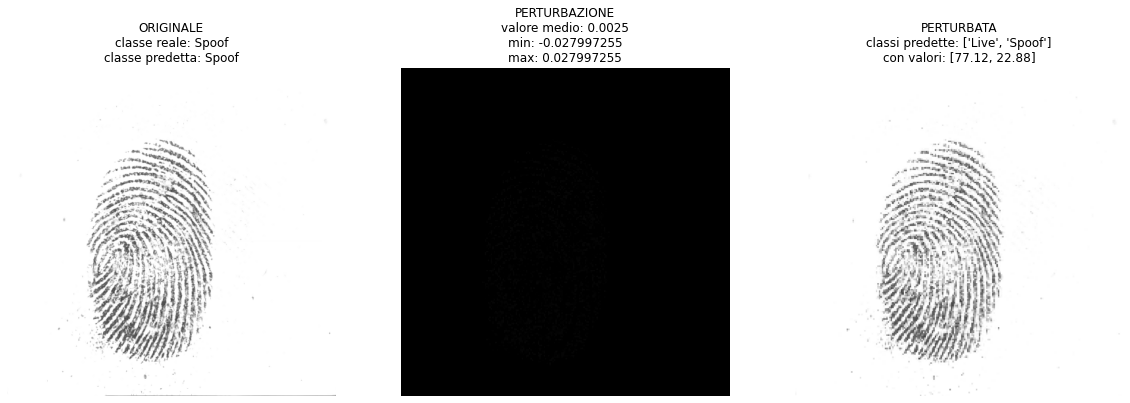

In [ ]:
#da usare nel test finale
preds_orig=Test_orig[1000:].predicted.values[list_print]
print(preds_orig)
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv)

###dataset ridotto

IMMAGINE  0


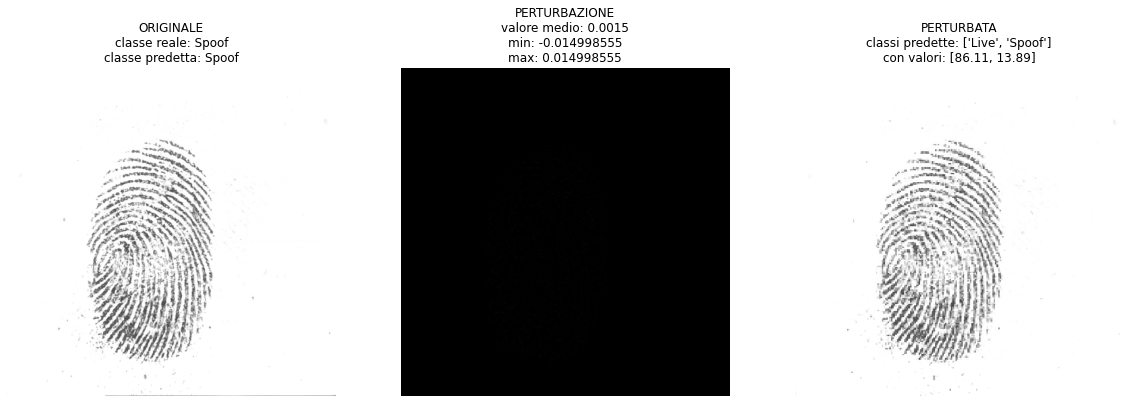

In [21]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_,_=test_average(classifier,input,transf_init)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
preds_orig=preds_orig[list_print]
preds_orig=np.array([classes_name[i] for i in preds_orig])
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv)

#salvataggio e lettura immagine

In [22]:
save_read(x_print_adv[0],classifier,transf_init)

valori img originale:
(0, array([0.8610581 , 0.13894185], dtype=float32), [1.188116118311882, -0.6359903573989868])
valori dopo salvataggio/lettura:
(0, array([0.86913776, 0.13086224], dtype=float32), [1.2213312089443207, -0.6720253169536591])
